# Impact Auxiliary Functions

We know that the impact analysis can be exaustive wtih different and diverse datasets. Therefore we developed a few methods to help you aggregate data both on time and space, and geolocate a excel spreadsheet or csv file. We are going to use the SG (Sindrome Gripal, Flu Syndrome) data from DATASUS which is in the csv format, and we rely on `pandas` and `geopandas` to to this analysis.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import climattr as eea
import matplotlib.pyplot as plt

In [2]:
sg_filename = '/home/rafael/oxford/impacts/datasus_sg/prep/sg_city-daily_2020-2024.csv'
city_filename = '/home/rafael/oxford/impacts/supplementary/shapefiles/BR_Municipios_2022/BR_Municipios_2022.shp'
state_filename = '/home/rafael/oxford/impacts/supplementary/shapefiles/BR_UF_2022/BR_UF_2022.shp'

First we load the SG data into a dataframe. The data is aggregated by city, so we want to geolocate the dataset based on the municipal level.

In [3]:
sg_dataframe = pd.read_csv(sg_filename, parse_dates=True)

sg_dataframe.head()

/tmp/ipykernel_11047/2808336251.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sg_dataframe = pd.read_csv(sg_filename, parse_dates=True)


,id,state_notification,city_notification,health_professional,security_professional,age,gender,race_color,code_member_of_traditional_community,state_residency,...,conditions.advanced_chronic_kidney_disease,conditions.decompensated_chronic_respiratory_diseases,conditions.pregnant,conditions.immunosuppression,conditions.obesity,conditions.others,conditions.chromosomal_diseases_or_state_of_immunological_fragility,conditions.postpartum,source,update_time
0,MIJJDjlT3d,GO,LUZIANIA,False,False,21,M,Ignored,False,GO,...,False,False,False,False,False,False,False,False,https://dados.gov.br/dados/conjuntos-dados/not...,2024-09-20 08:02:20.300220
1,dAfFRHXGx9,SP,SANTOS,False,False,67,F,White,False,SP,...,False,True,False,False,False,False,False,False,https://dados.gov.br/dados/conjuntos-dados/not...,2024-09-20 08:02:20.300220
2,AaMNz5I1u8,BA,VITORIA DA CONQUISTA,False,False,1,F,Brown,False,BA,...,False,False,False,False,False,False,False,False,https://dados.gov.br/dados/conjuntos-dados/not...,2024-09-20 08:02:20.300220
3,4hLECLGPoT,MG,NOVA LIMA,False,False,48,M,White,False,MG,...,False,False,False,False,False,True,False,False,https://dados.gov.br/dados/conjuntos-dados/not...,2024-09-20 08:02:20.300220
4,JnnpHLkT7E,SC,JOINVILLE,False,False,34,F,White,False,SC,...,False,False,False,False,False,False,False,False,https://dados.gov.br/dados/conjuntos-dados/not...,2024-09-20 08:02:20.300220


Before geolocalizing the dataframe we aggregate the data by counting the number of occurences by year in the column `id` (since we are counting we could have chosen any column to do that). We also calculate the logarithm of the cases and add it to a new column

In [4]:
sg_dataframe = eea.impacts.aggregate_time_dataframe(sg_dataframe, 'id', 'count', date='date_first_symptoms', freq='YE', location_column='city_residency')

# calculate log of cases
sg_dataframe['log_count'] = np.log10(sg_dataframe['id'])

sg_dataframe.head()

/home/rafael/miniconda3/envs/impact-env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,city_residency,date_first_symptoms,id,log_count
0,ABADIA DOS DOURADOS,2024-12-31 00:00:00+00:00,1,0.000000
1,ACAILANDIA,2024-12-31 00:00:00+00:00,1,0.000000
2,ACRELANDIA,2024-12-31 00:00:00+00:00,3,0.477121
3,ACREUNA,2024-12-31 00:00:00+00:00,2,0.301030
4,ADAMANTINA,2024-12-31 00:00:00+00:00,7,0.845098


We then load into memory the shapefile with the cities.

In [5]:
city_geodataframe = gpd.read_file(city_filename)

city_geodataframe.head()

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2..."
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1..."
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.52408 -13.32137, -60.37162 -13.3..."
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.35502 -11.50452, -61.35524 -11.5..."
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-60.82135 -13.1191, -60.81773 -13.12..."


Now we are going to geolocate the dataframe based on the city shapefile keeping all dates and cities, even if there aren't any cases for that particular year for that city.

In [6]:
sg_geodataframe = eea.impacts.geolocate_dataframe(sg_dataframe, city_geodataframe, dataframe_column='city_residency', cross_join_date=True, date='date_first_symptoms')
sg_geodataframe['log_count'] = sg_geodataframe['log_count'].fillna(0)

sg_geodataframe.head()

,city_residency,date_first_symptoms,id,log_count,geometry
0,ALTA FLORESTA D'OESTE,2024-12-31 00:00:00+00:00,NaN,0.0,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2..."
1,ALTA FLORESTA D'OESTE,2021-12-31 00:00:00+00:00,NaN,0.0,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2..."
2,ALTA FLORESTA D'OESTE,2022-12-31 00:00:00+00:00,NaN,0.0,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2..."
3,ALTA FLORESTA D'OESTE,2023-12-31 00:00:00+00:00,NaN,0.0,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2..."
4,ALTA FLORESTA D'OESTE,2020-12-31 00:00:00+00:00,NaN,0.0,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2..."


We select the year of 2024 to plot the data and visualize how it looks.

<Axes: >

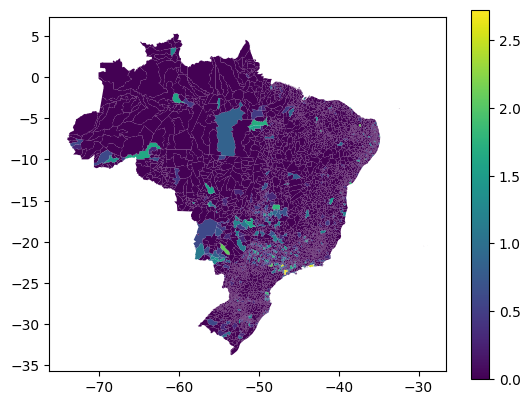

In [7]:
sg_geodataframe[sg_geodataframe['date_first_symptoms'] == '2024-12-31'].plot(column='log_count', legend=True)

If we want to aggregate spatially based on the states we could use the `eea.impacts.aggregate_spatial_dataframe` method that will use the shapefile of the states to check which cities are inside each state and aggregate the number of incidences. For this case we are aggregating by summing all cases in each state.

In [8]:
states_geodataframe = gpd.read_file(state_filename)
sg_state_geodataframe = eea.impacts.aggregate_spatial_dataframe(sg_geodataframe, states_geodataframe, 'id', 'sum', 'NM_UF', keep_date=True, date_column='date_first_symptoms')

sg_state_geodataframe.head()

,NM_UF,date_first_symptoms,id,geometry
0,ACRE,2020-12-31 00:00:00+00:00,0.0,"POLYGON ((-68.79282 -10.99957, -68.79367 -10.9..."
1,ACRE,2021-12-31 00:00:00+00:00,0.0,"POLYGON ((-68.79282 -10.99957, -68.79367 -10.9..."
2,ACRE,2022-12-31 00:00:00+00:00,0.0,"POLYGON ((-68.79282 -10.99957, -68.79367 -10.9..."
3,ACRE,2023-12-31 00:00:00+00:00,0.0,"POLYGON ((-68.79282 -10.99957, -68.79367 -10.9..."
4,ACRE,2024-12-31 00:00:00+00:00,41.0,"POLYGON ((-68.79282 -10.99957, -68.79367 -10.9..."


After that we calculate the logarithm again and plot for the year of 2024.

/home/rafael/miniconda3/envs/impact-env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

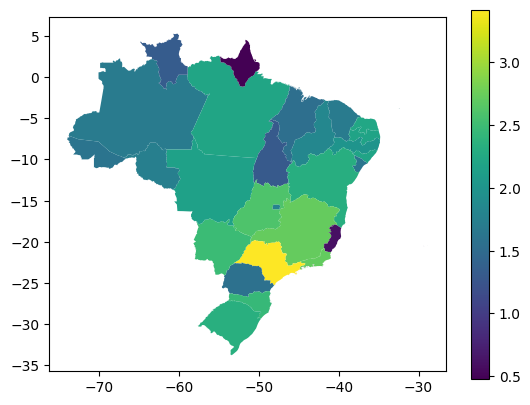

In [9]:
sg_state_geodataframe['log_count'] = np.log10(sg_state_geodataframe['id'])
sg_state_geodataframe['log_count'] = sg_state_geodataframe['log_count'].fillna(0)

sg_state_geodataframe[sg_state_geodataframe['date_first_symptoms'] == '2024-12-31'].plot(column='log_count', legend=True)